In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import pycountry
from transformers import pipeline
from tqdm.auto import tqdm
import torch
%matplotlib inline

In [ ]:
# 데이터 불러오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./submission.csv')

In [4]:
col = [
    'business_unit', # MQL 요청 상품에 대응되는 사업부
    'customer_country.1', # 담당 자사 법인명 기반의 지역 정보(대륙)
    'business_area', # 고객의 사업 영역
    'business_subarea', # 고객의 세부 사업 영역
    'is_converted',
]

In [5]:
df_train = df_train[col]
df_test = df_test[col]

In [6]:
# True로 예측된 개수
num_true = sum(df_train['is_converted'] == 1)
print(f'Number of Total Train length: {len(df_train)}')
print(f"Number of True: {num_true}")
print(f'Number of Total Test length: {len(df_test)}')

Number of Total Train length: 59299
Number of True: 4850
Number of Total Test length: 5271


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59299 entries, 0 to 59298
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   business_unit       59299 non-null  object
 1   customer_country.1  59299 non-null  object
 2   business_area       59299 non-null  object
 3   business_subarea    5526 non-null   object
 4   is_converted        59299 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 2.3+ MB


# business_unit

In [8]:
print(df_train['business_unit'].unique())
print(df_test['business_unit'].unique())

['AS' 'ID' 'IT' 'Solution' 'CM']
['ID' 'IT' 'AS']


# customer_country.1

In [7]:
def find_country(text):
    # 모든 국가를 순회하며 이름이 문자열 내에 있는지 확인
    for country in pycountry.countries:
        # 국가의 공식 이름, 일반 이름, 또는 단순 이름을 찾습니다.
        try:
            if country.name in text:
                return country.name
            #if country.common_name in text:
            #    return country.common_name
            if country.official_name in text:
                return country.official_name
        except AttributeError:
            # 공식 이름 또는 일반 이름 속성이 없는 경우, 무시합니다.
            continue
    return None  # 국가를 찾지 못한 경우

In [8]:
def standardize_address(address):
    if isinstance(address, str):
        # 주소를 '/' 기준으로 분리하고 앞뒤 공백 제거
        parts = address.strip('/').split('/')
        parts = [part.strip() for part in parts]
        
        # 전체 문자열에서 국가 이름 추출 시도
        country = find_country(address)
        if country:
            return country.title()  # 국가 이름을 제목 형식으로 변환
        else:
            return "Unknown"  # 국가를 찾지 못한 경우 'Unknown'으로 반환
    return "Invalid"  # 주소가 문자열이 아닌 경우 'Invalid'로 표시

In [9]:
# 함수 적용
df_train['customer_country.1'] = df_train['customer_country.1'].apply(standardize_address)
df_test['customer_country.1'] = df_test['customer_country.1'].apply(standardize_address)

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [10]:
df_train['customer_country.1'].unique()

array(['Philippines', 'India', 'Niger', 'Saudi Arabia', 'Benin',
       'Singapore', 'Brazil', 'Unknown', 'South Africa', 'United States',
       'Colombia', 'Mexico', 'Ghana', 'Egypt', 'Congo', 'Ethiopia',
       'Australia', 'Invalid', 'Kenya', 'Indonesia', 'Oman', 'Pakistan',
       'United Kingdom', 'Guatemala', 'Panama', 'Canada', 'Bangladesh',
       'Guinea', 'United Republic Of Tanzania', 'Qatar', 'Afghanistan',
       'Chile', 'Mozambique', 'Türkiye', 'El Salvador', 'Togo', 'Jordan',
       'Iraq', 'Israel', 'Sri Lanka', 'Portugal', 'Mauritania', 'Uruguay',
       'Peru', 'Germany', 'Romania', 'Norway', 'Jamaica', 'Hungary',
       'Poland', 'Spain', 'Argentina', 'Ecuador', 'Senegal', 'Hong Kong',
       'Malaysia', 'Japan', 'Kuwait', 'Ireland', 'Albania', 'Greece',
       'Algeria', 'Nicaragua', 'Slovenia', 'Italy', 'Netherlands',
       'Dominica', 'France', 'Uganda', 'Paraguay', 'Namibia', 'Tunisia',
       'Puerto Rico', 'Anguilla', 'Croatia', 'Fiji', 'Denmark', 'Sweden',


# business_area

In [11]:
print(df_train['business_area'].unique())
print(df_test['business_area'].unique())

['corporate / office' nan 'education' 'hotel & accommodation'
 'hospital & health care' 'special purpose' 'residential (home)'
 'government department' 'retail' 'factory'
 'power plant / renewable energy' 'transportation' 'public facility']
['retail' 'transportation' 'hospital & health care' 'corporate / office'
 nan 'residential (home)' 'education' 'factory' 'special purpose'
 'hotel & accommodation' 'public facility' 'government department'
 'power plant / renewable energy']


In [12]:

#from concurrent.futures import ThreadPoolExecutor, as_completed

In [13]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
texts_train = df_train['business_area'].fillna("Unknown").tolist()  # 결측치 처리
texts_test = df_test['business_area'].fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [14]:
intent_categories = [
    'Corporate / Office',  # 기업 / 사무실
    'Education',  # 교육
    'Hotel & Accommodation',  # 호텔 및 숙박
    'Hospital & Health Care',  # 병원 및 건강 관리
    'Special Purpose',  # 특수 목적
    'Residential (Home)',  # 주거(집)
    'Government Department',  # 정부 부서
    'Retail',  # 소매
    'Factory',  # 공장
    'Power Plant / Renewable Energy',  # 발전소 / 재생 에너지
    'Transportation',  # 교통
    'Public Facility',  # 공공 시설
    'Not Specified'  # 명시되지 않음
]


In [15]:
# 텍스트 데이터셋의 의도 분류 함수
def classify_intents(texts, classifier, categories):
    classified_intents = []
    for text in tqdm(texts, desc="Classifying intents"):
        # 분류 실행
        result = classifier(text, categories, multi_label=False)
        # 가장 가능성이 높은 카테고리 선택
        top_intent = result['labels'][0]
        classified_intents.append(top_intent)
    return classified_intents

In [16]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
intents_train = classify_intents(texts_train, classifier, intent_categories)

Classifying intents:   0%|          | 0/59299 [00:00<?, ?it/s]

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [17]:
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
intents_test = classify_intents(texts_test, classifier, intent_categories)

Classifying intents:   0%|          | 0/5271 [00:00<?, ?it/s]

In [18]:
df_train['business_area'] = intents_train
df_test['business_area'] = intents_test

# business_subarea

In [14]:
print(df_train['business_subarea'].unique())
print(df_test['business_subarea'].unique())

['Engineering' 'Advertising' 'Construction' 'IT/Software' nan
 'Manufacturing' 'Energy' 'Developer/Property' 'Entertainment'
 'Agriculture' 'Pharmaceutical' 'Others' 'Banking' 'Consulting'
 'Healthcare' 'Finance' 'Broadcasting & Media' 'Distribution Center'
 'Law Firm' 'Logistics' 'Telecommunication' 'Aerospace' 'Network/Cabling'
 'Insurance' 'Institute & Academy' 'Hotel' 'K12 Kindergarten & Schools'
 'Hospital' 'Mixed-use (Multi Complex)'
 'Telecom Base Station / Data, Call' 'Botanical Garden / Green House'
 'Higher Education (College & University)' 'Clinic' 'General Hospital'
 'Fitness' 'LTC(Long-Term Care)' 'Villa / Single-Family Home' 'Apartment'
 'Townhouse' 'Officetel' 'General Government Office' 'Military'
 'Police / Fire station' 'Welfare Facilities' 'Other Stores'
 'Luxury(Watch/Jewelry Shop)' 'Electronics & Telco' 'Sports Entertainment'
 'CVS (Convenience Store)' 'Car Dealership' 'Fashion'
 'QSR(Quick Service Restaurant)' 'Hyper Market & Grocery' 'Shopping Mall'
 'Cosmetics' 

In [15]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
texts_train = df_train['business_subarea']#.fillna("Unknown").tolist()  # 결측치 처리
texts_test = df_test['business_subarea']#.fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [16]:
intent_categories = [
    'Engineering',  # 공학
    'Construction',  # 건설
    'IT and Software',  # IT 및 소프트웨어
    'Manufacturing',  # 제조
    'Energy',  # 에너지
    'Property Development',  # 부동산 개발
    'Entertainment and Media',  # 엔터테인먼트 및 미디어
    'Education',  # 교육
    'Healthcare',  # 보건 의료
    'Government and Public Services',  # 정부 및 공공 서비스
    'Retail and Consumer Services',  # 소매 및 소비자 서비스
    'Hospitality',  # 호스피탈리티
    'Financial Services',  # 금융 서비스
    'Transportation and Logistics',  # 운송 및 물류
    'Telecommunication',  # 통신
    'Aerospace',  # 항공 우주
    'Agriculture and Forestry',  # 농업 및 임업
    'Pharmaceutical',  # 제약
    'Insurance',  # 보험
    'Real Estate',  # 부동산
    'Food and Beverage',  # 식음료
    'Legal Services',  # 법률 서비스
    'Sports and Recreation',  # 스포츠 및 레크리에이션
    'Energy Storage and Saving',  # 에너지 저장 및 절약
    'Mining',  # 광업
    'Not Specified'  # 명시되지 않음
]


In [19]:
# 텍스트 데이터셋의 의도 분류 함수 (결측치 처리 포함)
def classify_intents(texts, classifier, categories):
    # 결측치가 아닌 데이터만 필터링
    non_missing_texts = texts.dropna().reset_index(drop=True)
    
    # 결측치가 아닌 데이터에 대해 분류 실행
    classified_intents = []
    for text in tqdm(non_missing_texts, desc="Classifying intents"):
        result = classifier(text, categories, multi_label=False)
        classified_intents.append(result['labels'][0])
    
    # 원본 데이터의 인덱스를 유지하기 위해 전체 결과 리스트를 재구성
    final_intents = []
    classified_index = 0  # 분류된 데이터의 인덱스 추적
    for original_index in range(len(texts)):
        if pd.isna(texts.iloc[original_index]) or texts.iloc[original_index].strip() == "":
            final_intents.append("Not Specified")
        else:
            final_intents.append(classified_intents[classified_index])
            classified_index += 1
            
    return final_intents

In [20]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
intents_train = classify_intents(texts_train, classifier, intent_categories)

Classifying intents:   0%|          | 0/5526 [00:00<?, ?it/s]

In [21]:
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
intents_test = classify_intents(texts_test, classifier, intent_categories)

Classifying intents:   0%|          | 0/1816 [00:00<?, ?it/s]

In [22]:
df_train['business_subarea'] = intents_train
df_test['business_subarea'] = intents_test

In [24]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59299 entries, 0 to 59298
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   business_unit       59299 non-null  object
 1   customer_country.1  59299 non-null  object
 2   business_area       59299 non-null  object
 3   business_subarea    59299 non-null  object
 4   is_converted        59299 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5271 entries, 0 to 5270
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   business_unit       5271 non-null   object
 1   customer_country.1  5271 non-null   object
 2   business_area       5271 non-null   object
 3   business_subarea    5271 non-null   object
 4   is_converted        5271 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 211.0+ KB
None


In [25]:
BUR_df_train = df_train.drop('is_converted', axis = 1)
BUR_df_test = df_test.drop('is_converted', axis = 1)

BUR_df_train.to_csv('./preprocessing_data/BUR(비즈니스단위및지역정보)_train.csv')
BUR_df_test.to_csv('./preprocessing_data/BUR(비즈니스단위및지역정보)_test.csv')

In [26]:
df_train = pd.read_csv('./preprocessing_data/BUR(비즈니스단위및지역정보)_train.csv')
target_train = pd.read_csv('./preprocessing_data/target_train.csv')
df_train = pd.merge(df_train, target_train, on='Unnamed: 0', how='left')

df_test = pd.read_csv('./preprocessing_data/BUR(비즈니스단위및지역정보)_test.csv')
target_test = pd.read_csv('./preprocessing_data/target_test.csv')
df_test = pd.merge(df_test, target_test, on='Unnamed: 0', how='left')

In [55]:
# df_train 데이터 프레임을 복사하여 새로운 데이터 프레임을 생성합니다.
df_train_transformed = df_train.copy()
df_test_transformed = df_test.copy()

# 'object' 타입 변수 목록을 가져옵니다.
object_columns = df_train_transformed.select_dtypes(include=['object']).columns

# 각 object 타입 변수에 대한 변환 비율을 저장하는 딕셔너리를 생성합니다.
conversion_rate_dict = {}

for column in object_columns:
    # 각 object 타입 변수에 대해 is_converted의 평균값을 계산합니다.
    conversion_rate = df_train_transformed.groupby(column)['is_converted'].mean()
    
    # 계산된 평균값을 딕셔너리에 저장합니다.
    conversion_rate_dict[column] = conversion_rate
    
    # 새로운 컬럼 이름을 설정합니다.
    new_column_name = f"{column}_conversion_rate"
    
    # 원본 데이터 프레임에 새로운 컬럼을 추가합니다. map 함수를 사용하여 각 행의 값에 대응하는 비율을 적용합니다.
    df_train_transformed[new_column_name] = df_train_transformed[column].map(conversion_rate)
    df_test_transformed[new_column_name] = df_test_transformed[column].map(conversion_rate_dict[column])

    # 테스트 데이터에 없는 카테고리의 경우 0 또는 평균값으로 처리합니다.
    df_test_transformed[new_column_name].fillna(df_test_transformed[new_column_name].mean(), inplace=True)

# 불필요한 컬럼을 제거합니다.
df_train = df_train_transformed.select_dtypes(include=['int64', 'float64', 'bool'])
df_test = df_test_transformed.select_dtypes(include=['int64', 'float64', 'bool'])

# 이제 df_train과 df_test는 변환된 특성을 포함하고 있습니다.

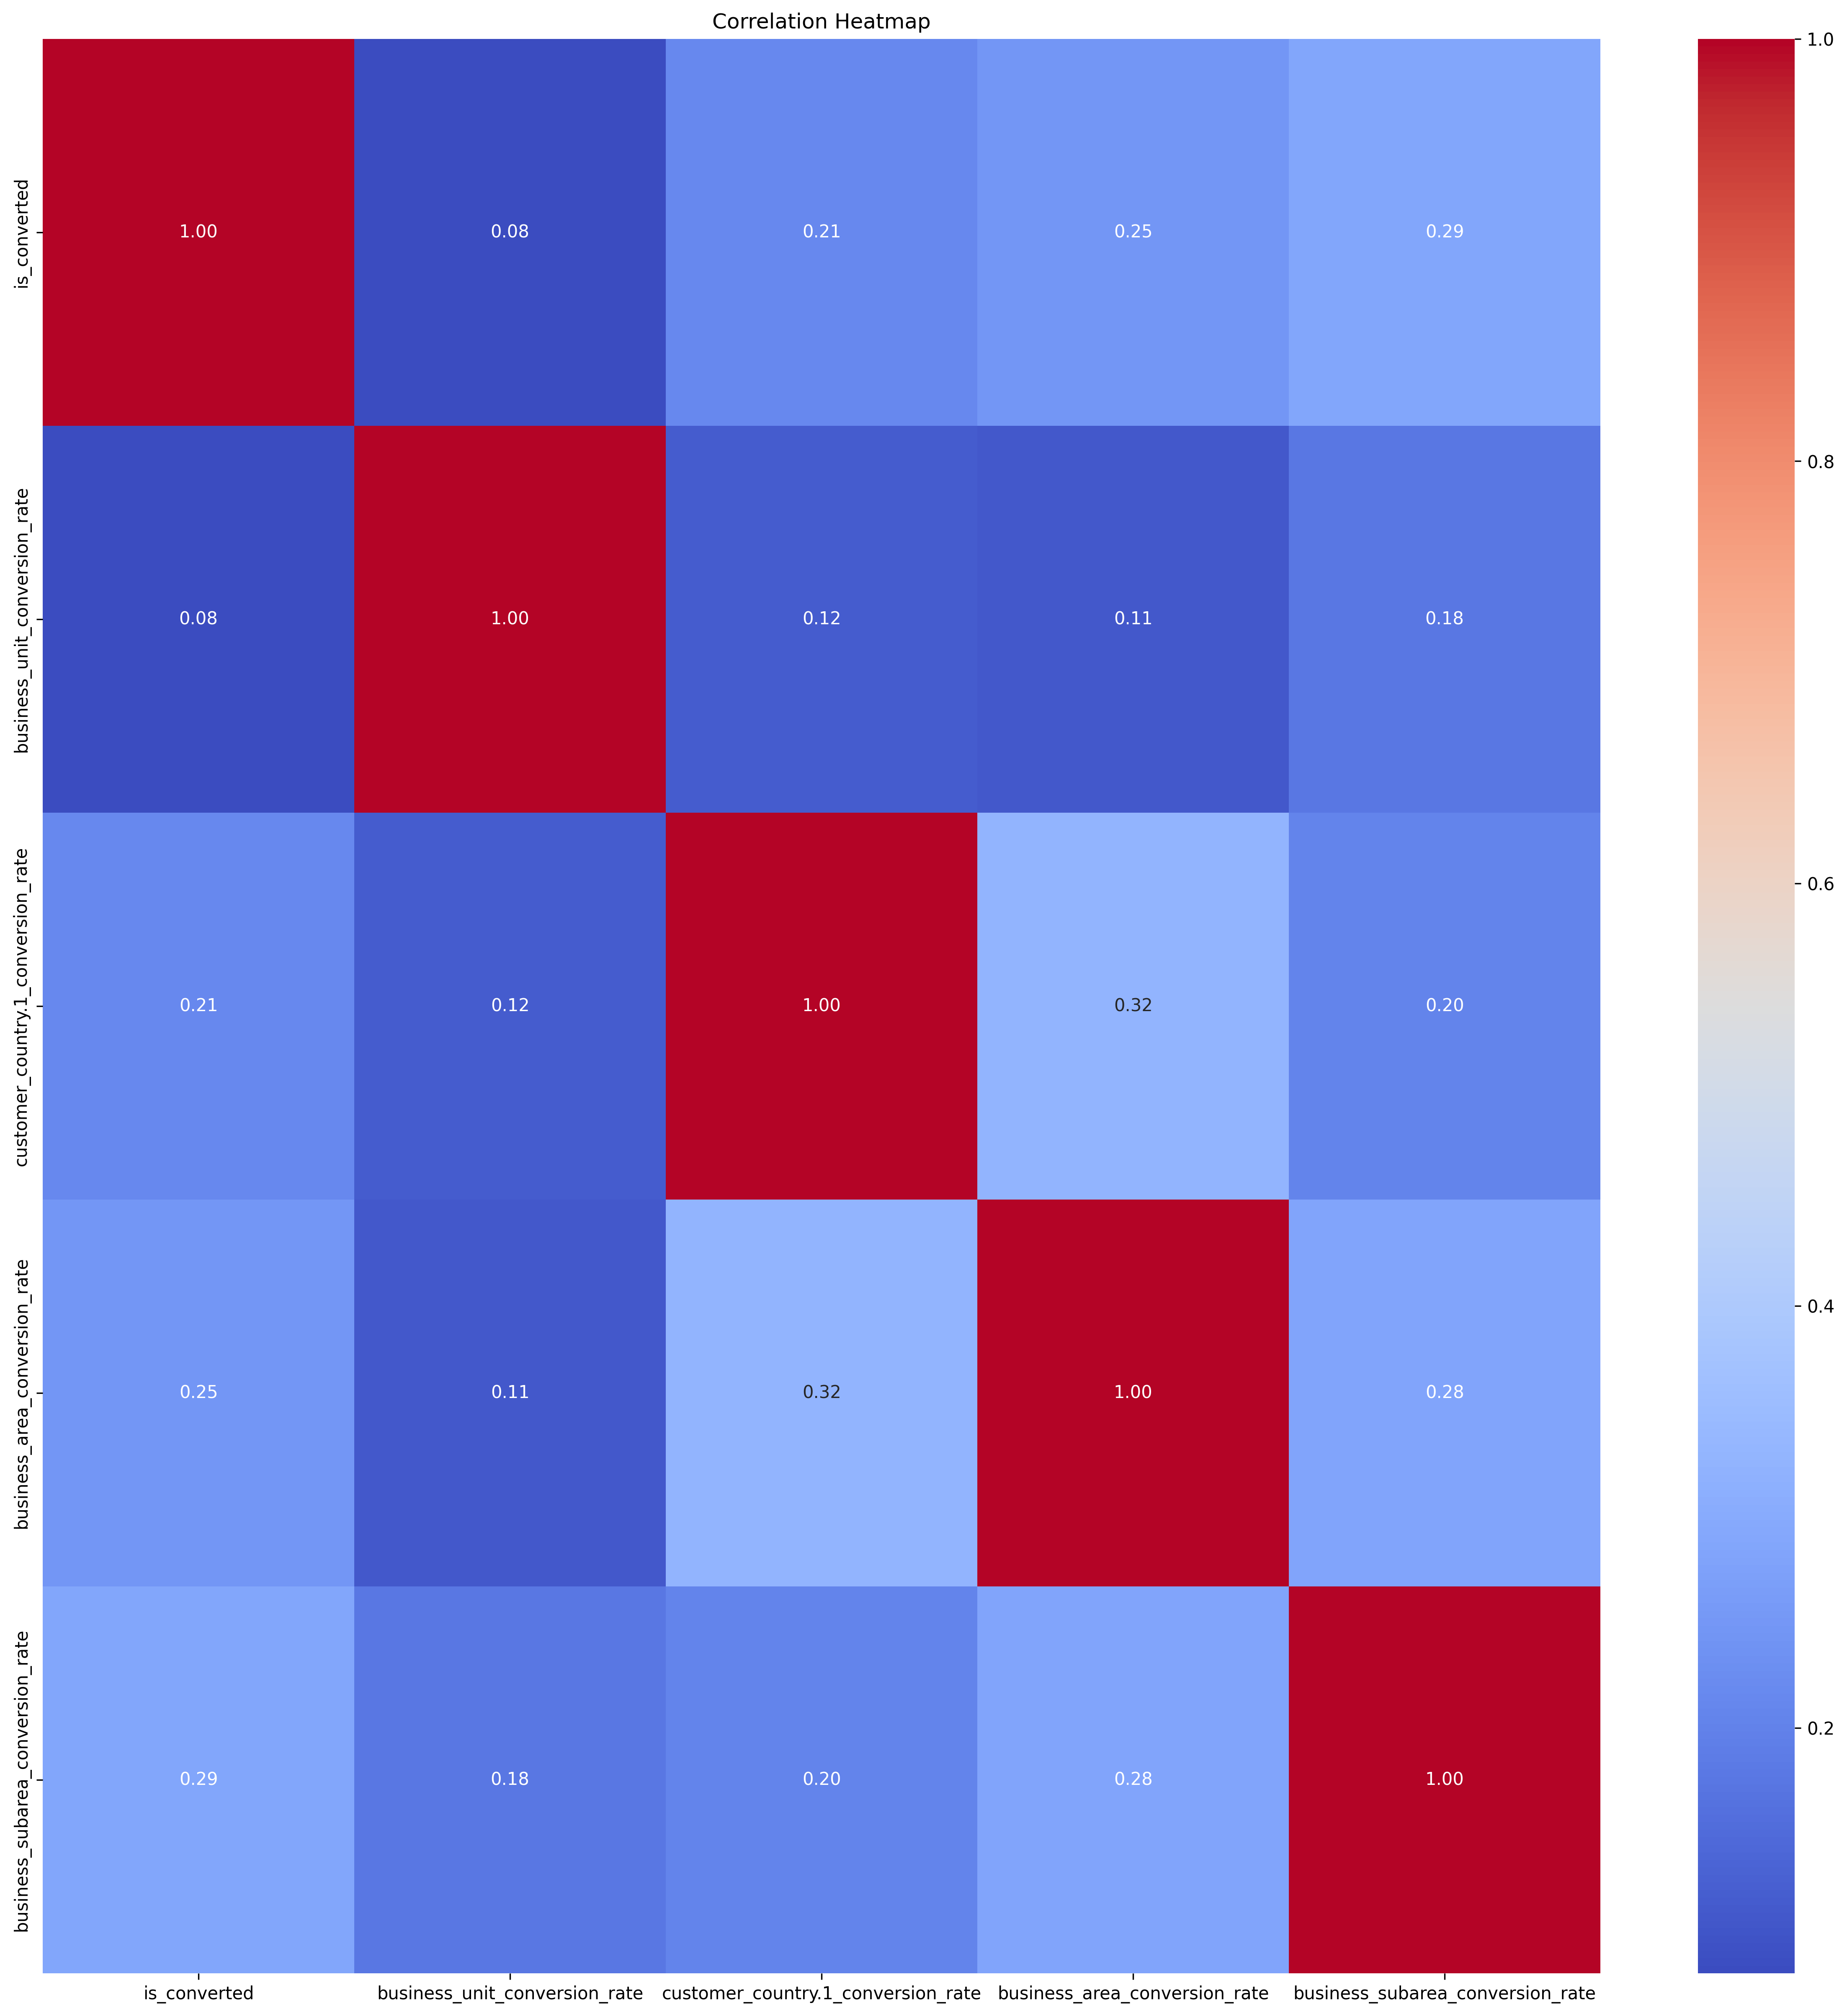

In [56]:
# 'is_converted'를 숫자형으로 변환 (True/False를 1/0으로)
df_train['is_converted'] = df_train['is_converted'].astype(int)

# 수치형 특성 선택
numerical_features = df_train.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()

# 상관계수 계산
correlation_matrix = df_train[numerical_features].corr()

# 히트맵 생성
plt.figure(figsize=(20, 20), dpi = 300)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
#plt.savefig('./corr.png') 

In [57]:
from pycaret.classification import *
clf = setup(data=df_train, 
            target='is_converted', 
            session_id=404, 
            use_gpu=True, 
            #normalize=True,  # 데이터 정규화
            #normalize_method='minmax',  # 정규화 방법
            #feature_selection=True,  # 특성 선택
            #remove_multicollinearity=True,  # 다중공선성 제거
            #categorical_imputation='lightgbm',  # 범주형 변수 결측치는 최빈값으로 대체
            #imputation_type='iterative',  # 반복적인(imputation) 방식 사용
            #categorical_features = col[:-1],
            verbose=True,
           )

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,404
1,Target,is_converted
2,Target type,Binary
3,Original data shape,"(59299, 5)"
4,Transformed data shape,"(59299, 5)"
5,Transformed train set shape,"(41509, 5)"
6,Transformed test set shape,"(17790, 5)"
7,Numeric features,4
8,Rows with missing values,90.7%
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [58]:
# 모델 비교
best_model = compare_models(sort='F1', cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9211,0.8026,0.1923,0.5532,0.2849,0.2533,0.2938,0.2030
dt,Decision Tree Classifier,0.9213,0.7904,0.1906,0.5576,0.2834,0.2523,0.2939,0.0220
xgboost,Extreme Gradient Boosting,0.9226,0.8089,0.1867,0.5862,0.2827,0.2532,0.3006,0.3940
et,Extra Trees Classifier,0.9216,0.7979,0.1873,0.5649,0.2808,0.2502,0.2939,0.1950
lightgbm,Light Gradient Boosting Machine,0.9214,0.8091,0.1432,0.5862,0.2280,0.2025,0.2605,0.0800
qda,Quadratic Discriminant Analysis,0.8974,0.6348,0.1835,0.2955,0.2261,0.1745,0.1803,0.0230
nb,Naive Bayes,0.8972,0.6379,0.1832,0.2940,0.2255,0.1736,0.1793,0.0140
lda,Linear Discriminant Analysis,0.9133,0.6849,0.1473,0.4159,0.2174,0.1824,0.2105,0.0230
knn,K Neighbors Classifier,0.9186,0.6894,0.1296,0.5072,0.2057,0.1787,0.2263,0.4160
catboost,CatBoost Classifier,0.9213,0.7957,0.0898,0.6378,0.1568,0.1395,0.2178,29.9960
